In [1]:
!pip install -Uqq fastai

In [2]:
from pathlib import Path
import pandas as pd
from fastai.vision.all import *
from fastai.callback.tracker import EarlyStoppingCallback
from scipy.io import loadmat

In [ ]:
# downloading images and delete false annotations file
path_data = untar_data(URLs.CARS, dest=Path.cwd())
path_annos = path_data/'cars_annos.mat'

# using try/except because of a bug in pathlib
try:
    path_annos.unlink(missing_ok=True)
except:
    pass

# downloading devkit containing true annotations
path_devkit = untar_data("https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz", dest=path_data)

# defining train and test paths
path_train = path_data/'cars_train'
path_test = path_data/'cars_test'

In [4]:
# converting classes to brands only
classes = loadmat(path_devkit/'cars_meta.mat')
classes_brands = [str(x[0]).split(" ")[0] for x in classes['class_names'][0]]

# getting class labels for each file in train and saving
# filenames along with classes and labels into a dataframe
cars_train_annos = loadmat(path_devkit/'cars_train_annos.mat')
cars_train_files_labels = [(x[-1][0][:], x[-2][0][0])  for x in cars_train_annos['annotations'][0]]
train_labels_df = pd.DataFrame(data=cars_train_files_labels,
                               columns=['fname', 'cls'])
# adding brands as labels
train_labels_df['lbl'] = [classes_brands[i-1] for i in train_labels_df['cls'].values]

# defining a function which extracts class labels for each sample
def label_func(fname, labels_df=train_labels_df):
    return labels_df.loc[labels_df['fname']==fname.name, 'lbl'].values[0]

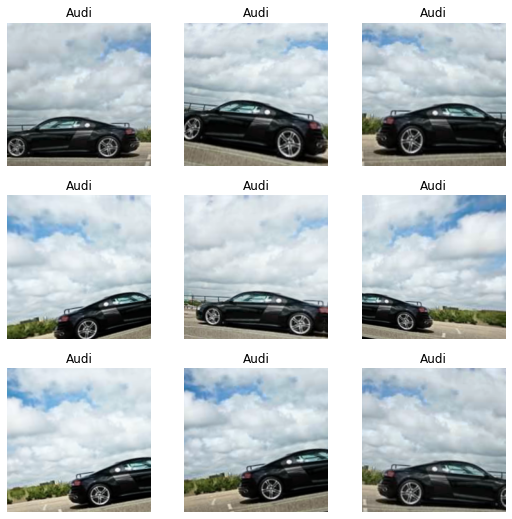

In [5]:
# Creating a DataBlock for the image data
cars = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y = label_func,
                   splitter = RandomSplitter(),
                   item_tfms = Resize(224),
                   batch_tfms=aug_transforms())

# Creating a DataLoaders object
dls = cars.dataloaders(path_train)

# Show a trainin batch to check if transformations are being applied as expected
dls.train.show_batch(unique=True)

In [ ]:
# Creating a Learner
learn = cnn_learner(dls, resnet50, metrics=error_rate)


Optimal learning rate 0.005754


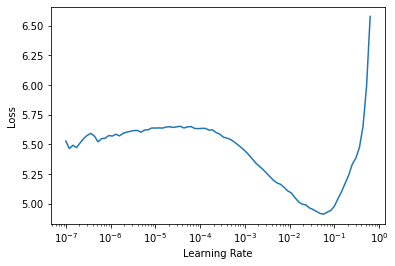

In [26]:
# Finding optimal learning rate
lr = learn.lr_find()
lr = lr[0]
print("Optimal learning rate {:2f}".format(lr))

In [35]:
# Fine-tuning the model using an EarlyStopping callback
learn.fine_tune(30, lr,
                freeze_epochs=3,
                cbs=EarlyStoppingCallback(min_delta=0.01, patience=2))

epoch,train_loss,valid_loss,error_rate,time
0,0.397171,0.601013,0.178133,01:28
1,0.408277,0.777711,0.213145,01:26
2,0.502750,0.858079,0.213759,01:27


No improvement since epoch 0: early stopping


epoch,train_loss,valid_loss,error_rate,time
0,0.406447,0.673883,0.179361,01:29
1,0.309142,0.738436,0.189189,01:29
2,0.320863,0.842765,0.201474,01:30


No improvement since epoch 0: early stopping


In [39]:
#  Using an interpreter for some additional info
interp = ClassificationInterpretation.from_learner(learn)

In [41]:
interp.print_classification_report()

               precision    recall  f1-score   support

           AM       1.00      0.80      0.89         5
        Acura       0.83      0.68      0.75        50
        Aston       0.79      0.91      0.85        34
         Audi       0.96      0.72      0.82       129
          BMW       0.63      0.94      0.76       101
      Bentley       0.92      0.86      0.89        57
      Bugatti       1.00      0.92      0.96        13
        Buick       0.64      0.72      0.68        25
     Cadillac       1.00      0.81      0.89        31
    Chevrolet       0.90      0.76      0.83       184
     Chrysler       0.64      0.83      0.72        53
       Daewoo       0.89      0.80      0.84        10
        Dodge       0.79      0.87      0.83       119
        Eagle       0.88      0.78      0.82         9
         FIAT       0.94      0.94      0.94        16
      Ferrari       0.97      0.82      0.89        38
       Fisker       1.00      1.00      1.00         3
         

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


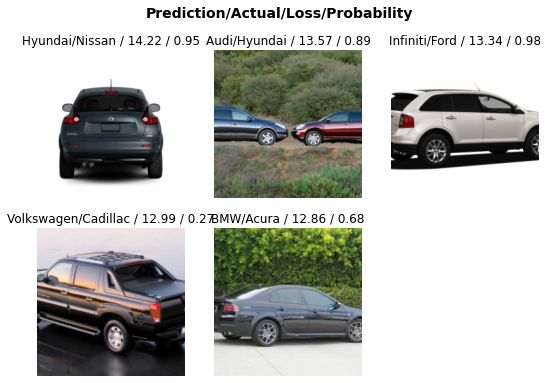

In [42]:
interp.plot_top_losses(k=5)

In [43]:
# Exporting the model
learn.export()


